## 12. GO/STOP! - Object Detection 시스템 만들기 [프로젝트]


In [179]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [197]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

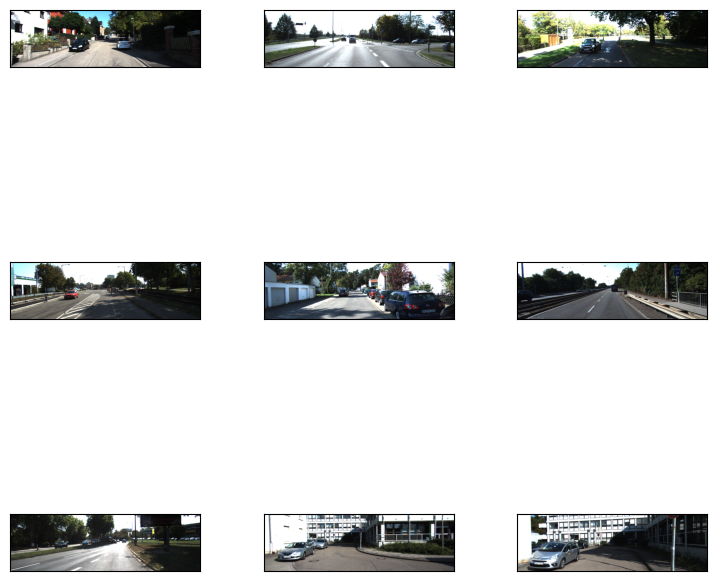

In [198]:
_ = tfds.show_examples(ds_train, ds_info)

In [199]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.3.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/root/tensorflow_datasets/kitti/3.3.0',
    file_format=tfrecord,
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/file_name': Text(shape=(), dtype=string),
        'objects': Sequence({
            'alpha': float32,

### 자율주행 보조시스템 -데이터 확인

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.21,  3.1 ], dtype=float32)>, 'bbox': <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.40533334, 0.54444444, 0.5241333 , 0.6501369 ],
       [0.46170667, 0.52062   , 0.52453333, 0.57110304]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1.45, 1.6 , 4.23],
       [1.48, 1.72, 3.99]], dtype=float32)>, 'location': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 4.48,  1.67, 25.08],
       [ 4.39,  1.86, 47.26]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 2])>, 'rotation_y': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.03, -3.1 ], dtype=float32)>, 'truncated': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>, 'type': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>}


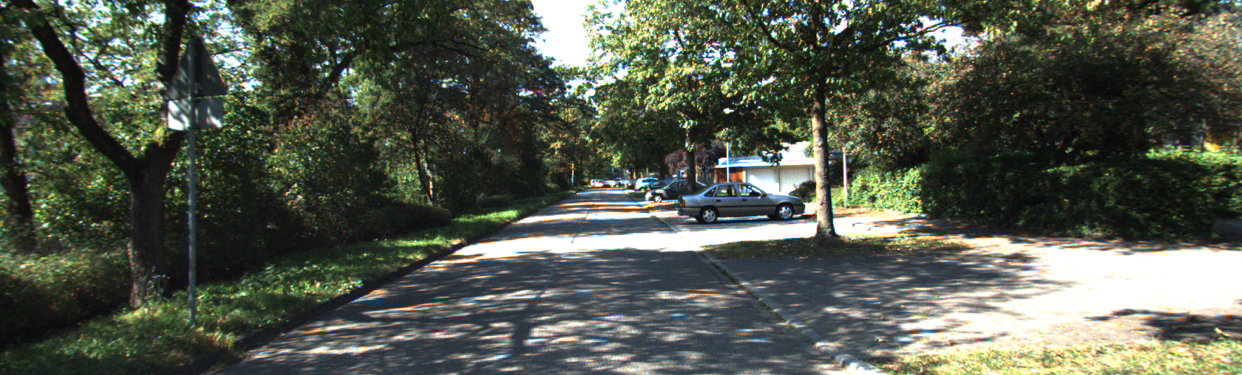

In [200]:
TakeDataset = ds_train.take(1)

for example in TakeDataset:
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1242  height: 375
(2, 4)
[676.2     223.      807.47003 178.45   ]
[646.61005 201.86    709.31    178.3    ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F051F1E3190>


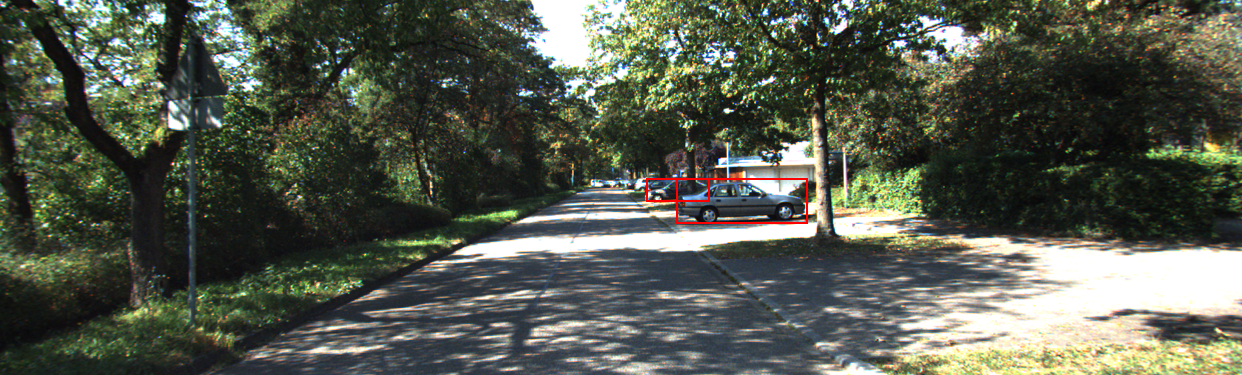

In [201]:
# 이미지 위에 바운딩 박스 그려 표시
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

In [204]:
#Keras-retinanet 실습 (1) 데이터 포맷 변경

import os
data_dir = os.getenv('HOME')+'/content/sample_data/kitti/3.3.0/data'
img_dir = os.getenv('HOME')+'/content/sample_data/kitti/3.3.0/kitti_images'
train_csv_path = data_dir + '/content/sample_data/kitti/3.3.0/kitti_train.csv'


In [211]:

# parse_dataset 함수를 구하기
def parse_dataset(dataset, img_dir="kitti_images", total=0):
  if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index
    # 저는 기존의 class를 차와 사람으로 나눔
  type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
  }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
  df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
  for item in tqdm(dataset, total=total):
      filename = item['image/file_name'].numpy().decode('utf-8')
      img_path = os.path.join(img_dir, filename)

      img = Image.fromarray(item['image'].numpy())
      img.save(img_path)
      object_bbox = item['objects']['bbox']
      object_type = item['objects']['type'].numpy()
      width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
      x_min = object_bbox[:,1] * width
      x_max = object_bbox[:,3] * width
      y_min = height - object_bbox[:,2] * height
      y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append함
      rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
      for i, _rect in enumerate(rects):
          _type = object_type[i]
          if _type not in type_class_map.keys():
              continue
          df = df.append({
              "img_path": img_path,
              "x1": _rect[0],
              "y1": _rect[1],
              "x2": _rect[2],
              "y2": _rect[3],
              "class_name": type_class_map[_type]
          }, ignore_index=True)
          break
          return df

          df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
          df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

* 이미지의 크기를 바꿀 때 고려할 점
; 이미지의 비율 유지, 이미지의 최대, 최소 크기도 제한

* 실제 입력할 이미지를 어떻게 바꿀지는 min_side, max_side, min_side_range, stride 등에 의해 결정

In [220]:
test_csv_path = data_dir + '/content/sample_data/kitti/3.3.0/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

FileNotFoundError: ignored

##클래스 맵핑

In [221]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

FileNotFoundError: ignored

##keras-retinanet 실습 (2) 셋팅

In [222]:
!cd ~/content/sample_data/kitti/3.3.0/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

/bin/bash: line 0: cd: /root/content/sample_data/kitti/3.3.0/object_detection: No such file or directory


In [223]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

/bin/bash: line 0: cd: /root/aiffel/object_detection: No such file or directory


##keras-retinanet 실습 (3) 시각화

In [224]:
mkdir -p ~/content/sample_data/kitti/3.3.0/object_detection/test_set
wget https://aiffelstaticprd.blob.core.windows.net/media/documents/test_set.zip
mv test_set.zip ~/aiffel/object_detection/test_set
cd /content/sample_data/kitti/3.3.0/object_detection/test_set && unzip test_set.zip


%matplotlib inline
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/content/sample_data/kitti/3.3.0/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

SyntaxError: ignored

In [225]:
import os
img_path = os.getenv('HOME')+'/content/sample_data/kitti/3.3.0/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()

inference_on_image(model, img_path=img_path)

NameError: ignored

In [226]:
img_path = os.getenv('HOME')+'/content/sample_data/kitti/3.3.0/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

NameError: ignored

##프로젝트: 자율주행 보조 시스템 만들기

1. 자율주행 시스템 만들기

입력으로 이미지 경로를 받습니다.

정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.

-사람이 한 명 이상 있는 경우

-차량의 크기(width or height)가 300px이상인 경우


In [227]:
def self_drive_assist(model, img_path, size_limit=300, visualize=True):
    result = "Go"
    image = read_image_bgr(img_path)

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0:(0,0,255),
        1:(255,0,0)
    }

    # 이미지 전처리
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # peocess image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score<0.5:
                break
            b = box.astype(int)

            if b[2]-b[0] >= 300 or b[3]-b[1] >= 300 or label == 1 :
                result = 'Stop'
            else:
                result = 'Go'

            draw_box(draw, b, color=color_map[label])

            caption = "{:3f}".format(score)
            draw_caption(draw, b, caption)
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.title(result, fontsize=20)
        plt.imshow(draw)
        plt.show()

        return result

### 인코딩

* One stage detector ;  ***anchor box***에서 위치, 크기, 비율 중에 하나로 물체의 위치가 결정 되므로 anchor box를 생성함

-> anchor box는 미리 정해진 object가 있음직한 box 를 의미함
-> 이때, anchor box로 생성되는 것은 물체의 가상위치임 (anchor box 는 기본적으로 center coordinate로 만듬)

** 하단 그림을 참고하면, 자동차와 사람이 겹쳐 있음. 이때, 두 물체를 모두 검출하기 위해서 다양한 종횡비(aspect ratio)와 크기(scale)로 이루어진 anchor box를 이용해서 모두 구하려 하면,
deep neural network를 통한 object detection은 출력이 convolution의 ouput인 2차원 그리드인 경우가 많은데, 각 그리드에서 여러가지 object를 검출 할 수 있도록 도와주는 미리 정해진 box임.

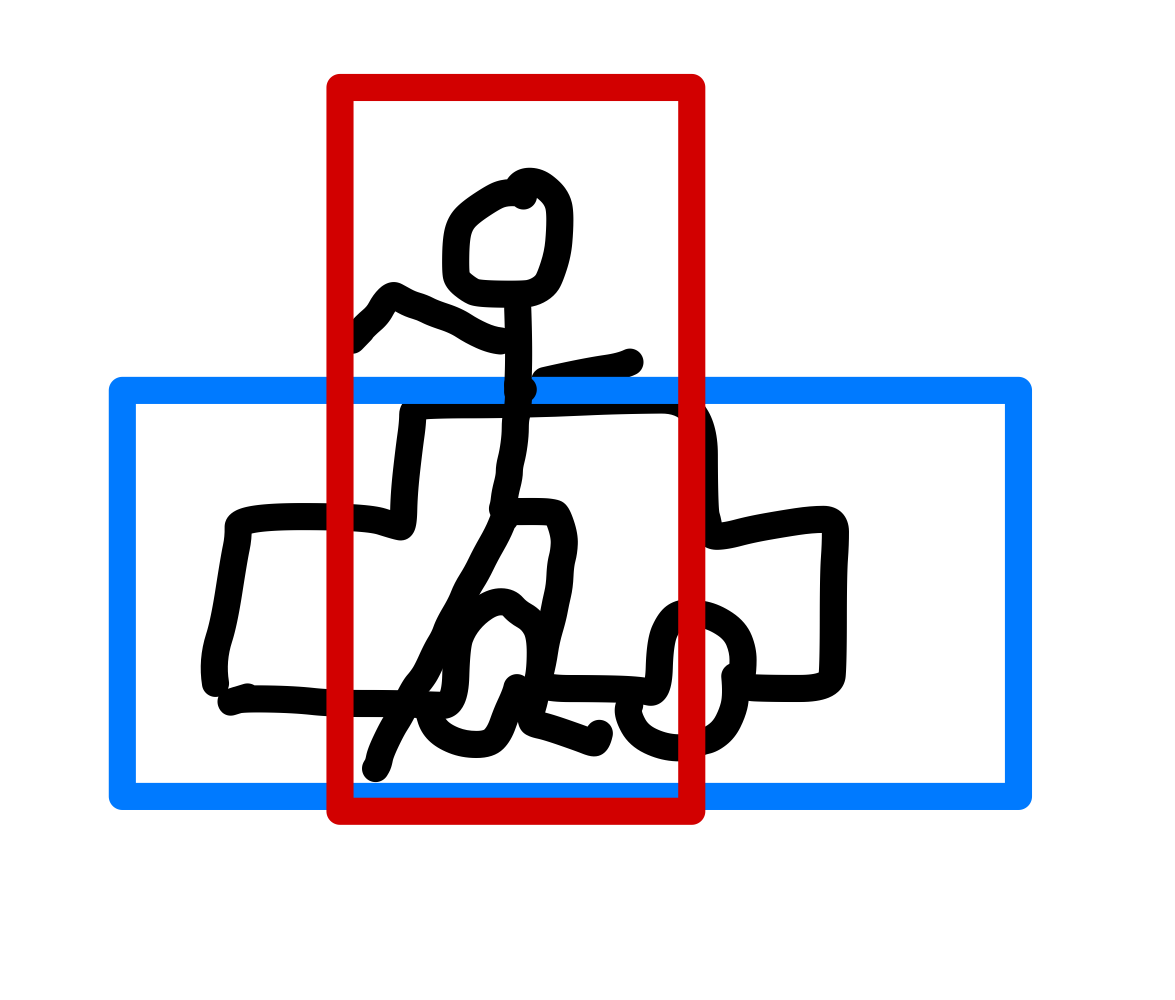





###모델 만들기 (RetinaNet 활용)

* 1-stage detector 모델 (YOLO, SSD) :  2-stage detector (Faster-RCNN) 보다 속도는 빠르지만 성능이 낮은 문제점이 있음

* RetinaNet에서는 **focal loss**와 Feature Pyramid Network가 적용된 네트워크를 사용!



* **Focal loss 필요성**

(1) Object Detection에는 크게 2가지 종류의 알고리즘이 있음.

R-CNN 계열의 two-stage detector,

YOLO, SSD 계열의 one-stage detector.

*(2) Focal Loss는 one-stage detector의 정확도 성능을 개선하기 위하여 필요함*

- one-stage detector가 two-stage detector에 비하여 가지고 있는 문제점은 학습 중 클래스 불균형 문제가 심하다는 것임

-문제점이 발생하는 이유는 dense sampling of anchor boxes 때문이라고 알려져 있음

-> 어렵거나 쉽게 오분류되는 케이스에 대하여 더 큰 가중치를 주는 방법을 사용함.

* class를 예측하는 head와 box를 예측하는 head가 별도로 존재한다는게 중요함

-> Object Detection의 라벨은 class와 box로 이루어지므로 각각 추론하는 부분이 존재하며 각각의 부분을 만들어주어야함

RetinaNet의 backbone은 ResNet50임

-> FPN에서 이용하기 위해 dense layer도 output으로 연결 해줄 것

backbone + FPN + classification용 head + box용 head



*   RetinaNet에서는 Focal loss를 사용하는데, Box regression에는 사용하지 않고 classification loss를 계산하는데만 사용.
*   box regression은 smooth L1 loss를 사용





## 자율주행 시스템 평가하기



In [228]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/content/sample_data/kitti/3.3.0/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        print(image_path)
        pred = self_drive_assist(model=model, img_path=image_path, visualize=True)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

In [ ]:
test_system(self_drive_assist)